### Test de modélisation avec un algo de classification "classique"

* Mise en oeuvre d'un réseau de neurones dense "simple"
* Application du tuto : https://www.tensorflow.org/tutorials/images/classification

### Import librairies

In [49]:
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import time
import os
import pathlib
import shutil
import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

### Sélection d'un jeu de données réduit pour tester le premier modèle 

In [11]:
metadata = pd.read_csv("../../data/metadata_compil.csv")
metadata.head()
classes = metadata["CLASS"].unique()

In [30]:
def extract_subset(dossier_source, dossier_cible, nombre_par_classe):
    #Parcourir les dossiers du dataset préprocessé
    for c in os.listdir(dossier_source):
        sous_dossier = os.path.join(dossier_source, c)
        #boucle sur un array randomisé entre 1 et le nombre de fichiers du dossier, contenant le nombre_par_classe
        for file in np.random.choice(os.listdir(sous_dossier), nombre_par_classe, replace = False):
            #chemin d'accès au fichier soruce
            src = os.path.join(sous_dossier, file)
            #chemin d'accès du fichier copié
            dst = os.path.join(dossier_cible, c, file)
            #copie
            shutil.copyfile(src, dst)


In [158]:
dossier_source = "../../data/Preprocessing_1/" 
dossier_cible = "../../Data/Train_val_set_1/"
nb_par_classe = 500

start_time = time.time()
extract_subset(dossier_source, dossier_cible, nb_par_classe)
print("--- %s seconds ---" % (time.time() - start_time))


--- 23.876904487609863 seconds ---


### 1er réseau de neurones denses

In [159]:
#1 : Import du dataset et compte des images
dossier_train = "../../Data/Train_val_set_1/"
data_dir = pathlib.Path(dossier_train).with_suffix('')
image_count = len(list(data_dir.glob('*/*.png')))
print(f"{image_count} images dans le dataset")

2000 images dans le dataset


In [160]:
#2 : Chargement du dataset dans Keras
#define parameters for loader
batch_size = 32
img_height = 256
img_width = 256


#Create train set 80%
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale")

#Create validation set 20%
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale")


Found 2000 files belonging to 4 classes.
Using 1600 files for training.
Found 2000 files belonging to 4 classes.
Using 400 files for validation.


In [161]:
#You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['COVID', 'LUNG OPACITY', 'NORMAL', 'VIRAL PNEUMONIA']


In [162]:
#Configure dataset for performance with CACHE (not loading images at each epoch) and PREFETCH (overlapping data processing and model execution)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
#STandardize layer as part of model
#Here, you will standardize values to be in the [0, 1] range by using 
normalization_layer = layers.Rescaling(1./255)

In [163]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 1)
(32,)


In [171]:
#Instanciation d'un premier modèle avec 2 couches 

num_classes = len(class_names)
#inputs = layers.Rescaling(1./255, input_shape=(img_height, img_width))
#first_layer = layers.Dense(16, activation = "tanh", kernel_initializer = "normal", name = "Dense1")
#second_layer = layers.Dense(4, activation = "softmax", kernel_initializer = "normal", name = "Dense2")
#x = first_layer(inputs)
#outputs = second_layer(x)
#model = Model(inputs = inputs, outputs = outputs)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
#  layers.Dropout(0.2),
#  layers.Flatten(),
  layers.Dense(128, activation='relu', name = "Dense2"),
  layers.Dense(32, activation='relu', name = "Dense5"),
  layers.Dense(num_classes, activation = "softmax", name = "Dense6")
])

#Compiler le modèle
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [172]:
#model summary
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_22 (Rescaling)    (None, 256, 256, 1)       0         
                                                                 
 dropout_4 (Dropout)         (None, 256, 256, 1)       0         
                                                                 
 flatten_16 (Flatten)        (None, 65536)             0         
                                                                 
 Dense2 (Dense)              (None, 128)               8388736   
                                                                 
 Dense5 (Dense)              (None, 32)                4128      
                                                                 
 Dense6 (Dense)              (None, 4)                 132       
                                                                 
Total params: 8392996 (32.02 MB)
Trainable params: 83

In [173]:
#Entraînement du modèle

#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Train model
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [callback]
)

Epoch 1/30


50/50 [==============================] - 10s 157ms/step - loss: 1.4046 - accuracy: 0.4563 - val_loss: 1.0097 - val_accuracy: 0.5375
Epoch 2/30
50/50 [==============================] - 8s 167ms/step - loss: 0.9625 - accuracy: 0.6131 - val_loss: 0.9891 - val_accuracy: 0.5350
Epoch 3/30
50/50 [==============================] - 8s 164ms/step - loss: 0.8133 - accuracy: 0.6562 - val_loss: 0.9404 - val_accuracy: 0.5800
Epoch 4/30
50/50 [==============================] - 8s 158ms/step - loss: 0.7100 - accuracy: 0.6975 - val_loss: 0.9887 - val_accuracy: 0.5900
Epoch 5/30
50/50 [==============================] - 8s 160ms/step - loss: 0.6540 - accuracy: 0.7269 - val_loss: 1.0044 - val_accuracy: 0.5600
Epoch 6/30
50/50 [==============================] - 9s 178ms/step - loss: 0.5944 - accuracy: 0.7525 - val_loss: 0.9755 - val_accuracy: 0.6100
Epoch 7/30
50/50 [==============================] - 8s 166ms/step - loss: 0.5059 - accuracy: 0.7969 - val_loss: 1.0232 - val_accuracy: 0.5700
Epoch 8/30
50/50

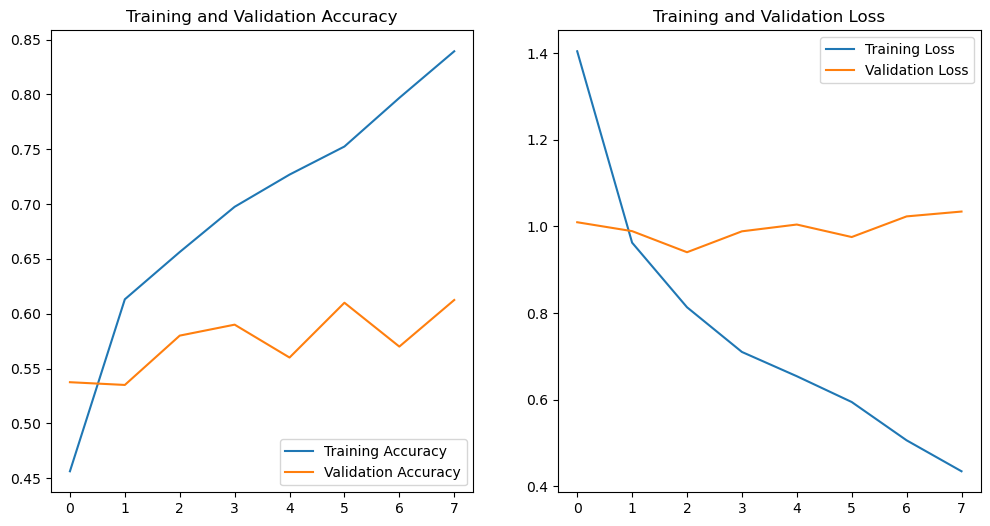

In [174]:
#Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





### 2 Réseau de convolution

In [175]:
# Ajout de couches de convolution

num_classes = len(class_names)

model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu', name = "Dense2"),
  layers.Dense(32, activation='relu', name = "Dense5"),
  layers.Dense(num_classes, activation = "softmax", name = "Dense6")
])

#Compiler le modèle
model2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#model summary
model2.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_23 (Rescaling)    (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)     

In [176]:
#Entraînement du modèle

#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Train model
epochs=30
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [callback]
)

Epoch 1/30


50/50 [==============================] - 52s 979ms/step - loss: 1.1291 - accuracy: 0.5169 - val_loss: 0.9634 - val_accuracy: 0.5550
Epoch 2/30
50/50 [==============================] - 48s 964ms/step - loss: 0.7915 - accuracy: 0.6694 - val_loss: 0.9046 - val_accuracy: 0.6000
Epoch 3/30
50/50 [==============================] - 53s 1s/step - loss: 0.5991 - accuracy: 0.7550 - val_loss: 0.8665 - val_accuracy: 0.6100
Epoch 4/30
50/50 [==============================] - 74s 1s/step - loss: 0.4725 - accuracy: 0.8181 - val_loss: 1.0355 - val_accuracy: 0.6075
Epoch 5/30
50/50 [==============================] - 58s 1s/step - loss: 0.3312 - accuracy: 0.8731 - val_loss: 1.0148 - val_accuracy: 0.6200
Epoch 6/30
50/50 [==============================] - 64s 1s/step - loss: 0.1936 - accuracy: 0.9356 - val_loss: 1.3681 - val_accuracy: 0.6450
Epoch 7/30
50/50 [==============================] - 47s 950ms/step - loss: 0.1238 - accuracy: 0.9575 - val_loss: 1.4074 - val_accuracy: 0.6525
Epoch 8/30
50/50 [====

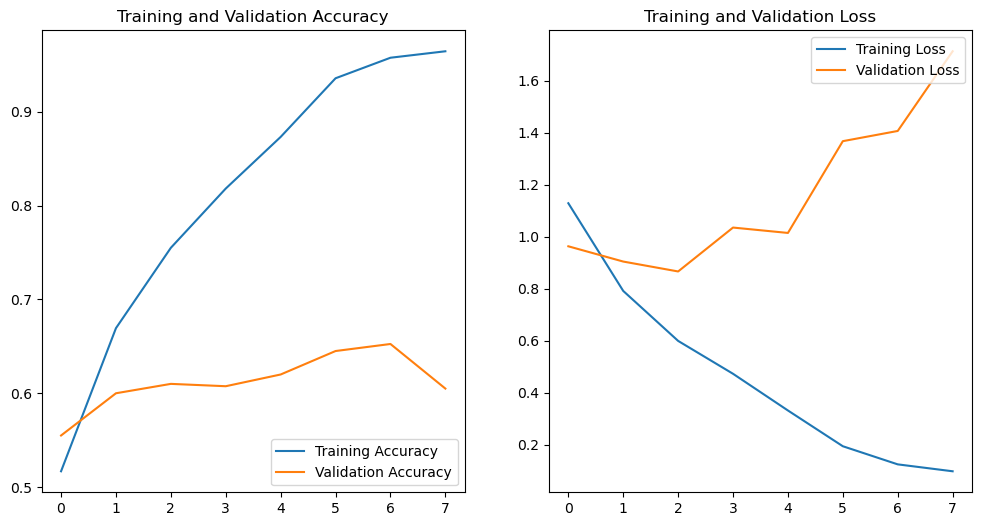

In [179]:
#Visualize training results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



